<a href="https://colab.research.google.com/github/ourekouch/Coursera_Capstone/blob/master/The_Battle_of_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd


In [188]:
!pip install beautifulsoup4
!pip install lxml
!pip install html5lib
!pip install requests 
!pip install geocoder
!pip install geopy
!pip install Nominatim
!pip install folium
!pip install requests
!pip install sklearn

**Introduction/Business Problem**

A constractor want to start a new business in fast food in london . Unfortunately he has no idea about the right area for this project.
So he decided to rely on the science of data analysis in order to find the appropriate area for this new project, 
especially the population density in various neighborhoods of London, as well as the distribution of different venues and facilities 
in the city of london .


**1.  Data acquisition : Data about London Boroughs and populations in london**


In this project we will use data from "https://en.wikipedia.org/wiki/List_of_London_boroughs" , but we need first to get data by scraping and clean it .

In [204]:
#importing libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np


#Source of Data
source  = requests.get("https://en.wikipedia.org/wiki/List_of_London_boroughs").text
soup=BeautifulSoup(source,'lxml')


#add an empty dataframe
df_london = pd.DataFrame(columns=['Borough','Population','Coord'])

#finding our data and scraping it using beautifulSoup library
table=soup.find('table')
body=table.find('tbody')
for row in body.find_all('tr'):
  List=[]
  for x in row.find_all('td'):
      List.append(x.text)
  list_df = pd.DataFrame(List)
  #for each row we check if the row has values and borough different to not assigned then we add row to dataframe
  if len(List)>0 :
    df2 = pd.DataFrame({'Borough':[List[0]], 'Population':[List[7]],'Coord':[List[8]]})  
    if List[1] != "Not assigned"   :
      df_london = df_london.append(df2,ignore_index=True)


#Data wrangling and data cleaning : 
df_london['Borough']=df_london['Borough'].astype(str).str.replace('\n','')
df_london['Population']=df_london['Population'].astype(str).str.replace('\n','')
df_london[['Latitude','Longitude']] = df_london.Coord.str.split("″N ",expand=True) 
df_london['Longitude'] = df_london.Longitude.str.split("/" ,expand=True) 
df_london['Borough'] = df_london.Borough.str.split("[" ,expand=True) 
df_london['Latitude']=df_london['Latitude'].astype(str).str.replace('°',',')
df_london['Latitude']=df_london['Latitude'].astype(str).str.replace('′','')
df_london['Longitude']=df_london['Longitude'].astype(str).str.replace('°',',')
df_london['Longitude']=df_london['Longitude'].astype(str).str.replace('′','')
df_london['Longitude']=df_london['Longitude'].astype(str).str.replace('″E','')
df_london.loc[df_london.Longitude.astype(str).str.contains('″W'), 'Longitude']='-'+df_london['Longitude'].astype(str)
df_london['Longitude']=df_london['Longitude'].astype(str).str.replace('″W','')
df_london['Longitude']=df_london['Longitude'].astype(str).str.replace('\ufeff','')
df_london['Latitude']=df_london['Latitude'].astype(str).str.replace('\ufeff','')
df_london['Population']=df_london['Population'].astype(str).str.replace(',','')


#replace , by . in order to make transformation object -> String : possible
df_london['Latitude']=df_london['Latitude'].astype(str).str.replace(',','.')
df_london['Longitude']=df_london['Longitude'].astype(str).str.replace(',','.')

#we don't need this column anymore 
del df_london['Coord']

#Transformation to numeric forme 
df_london['Latitude'] = pd.to_numeric(df_london['Latitude'])
df_london['Longitude'] = pd.to_numeric(df_london['Longitude'])
df_london['Population'] = pd.to_numeric(df_london['Population'])

#some changes in coordinate due to tranformation of Geographic Coordinates to Decimal
my_list1=[]
my_list2=[]
for i, row in df_london.iterrows():
  x=row['Latitude']
  x2=row['Longitude']
  y=100*(x-int(x))
  z=100*(y-int(y))
  y2=100*(x2-int(x2))
  z2=100*(y2-int(y2))
  my_list1.append(int(x) + y/60 + z/3600)
  my_list2.append(int(x2) + y2/60 + z2/3600)
df_london['Latitude'] = my_list1
df_london['Longitude'] = my_list2


#Finally our DATA 
df_london.head()


,Borough,Population,Latitude,Longitude
0,Barking and Dagenham,194352,51.567333,0.159333
1,Barnet,369088,51.630444,-0.152667
2,Bexley,236687,51.458000,0.150889
3,Brent,317264,51.564222,-0.290667
4,Bromley,317899,51.406222,0.021556


**2.   Data analysis : population and clusturing**

In this section we will use our data and forsquare api in order to get all informations about london boroughs that can help us to find a solution to the business problem



Text(0.5, 1.0, 'Top 5 Boroughs by Population on 2013')

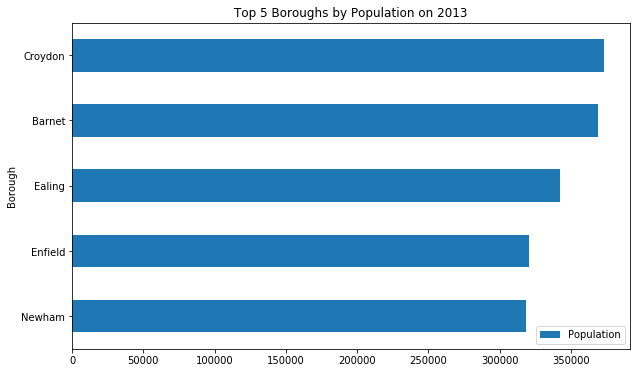

In [205]:
df_sorted=df_london[['Borough','Population']].sort_values(by='Population',ascending=True)
df_sorted.set_index('Borough', inplace=True)
df_sorted.tail(5).plot(kind='barh',stacked=True ,figsize=(10, 6))
plt.title('Top 5 Boroughs by Population on 2013')


In [206]:
import folium # map rendering library
import matplotlib.cm as cm
import matplotlib.colors as colors
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import matplotlib.pyplot as plt


address = 'London'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of London City are {}, {}.'.format(latitude, longitude))

# create map of London using latitude and longitude values
map_London = folium.Map(location=[latitude, longitude], zoom_start=10)



# add markers to map''
for lat, lng, borough in zip(df_london['Latitude'], df_london['Longitude'], df_london['Borough']):
    label = '{},{}'.format(borough,borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_London)
          

map_London

The geograpical coordinate of London City are 51.5073219, -0.1276474.


In [0]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    CLIENT_ID='G5TUS4T0FKE1X5DVH22U4I1SUFQD5FPUYVQVFBS5JVEBTGGU'
    CLIENT_SECRET='UZYX5HLCR3G3ZFBIANE5WLF4EY3FSRV5YOYWOMDK2NEPZXYF'
    VERSION = '20180604'
    LIMIT = 30
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [208]:
London_venues = getNearbyVenues(names=df_london['Borough'],
                                   latitudes=df_london['Latitude'],
                                   longitudes=df_london['Longitude']
                                  )

Barking and Dagenham 
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich 
Hackney
Hammersmith and Fulham 
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [209]:
# one hot encoding
London_onehot = pd.get_dummies(London_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
London_onehot['Neighborhood'] = London_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [London_onehot.columns[-1]] + list(London_onehot.columns[:-1])
London_onehot = London_onehot[fixed_columns]

London_onehot.head(20)

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bar,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Camera Store,Canal Lock,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Department Store,Dessert Shop,Diner,...,Pier,Pizza Place,Platform,Playground,Plaza,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoothie Shop,Soccer Field,Soccer Stadium,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Train Station,Tree,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Wine Shop,Women's Store
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Barnet,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,Barnet,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Barnet,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Barnet,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Bexley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,Bexley,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [210]:
London_grouped = London_onehot.groupby('Neighborhood').mean().reset_index()
London_grouped

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bar,Beer Bar,Beer Store,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Camera Store,Canal Lock,Cantonese Restaurant,Caribbean Restaurant,Chaat Place,Cheese Shop,Chinese Restaurant,Church,Clothing Store,Cocktail Bar,Coffee Shop,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Department Store,Dessert Shop,Diner,...,Pier,Pizza Place,Platform,Playground,Plaza,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoothie Shop,Soccer Field,Soccer Stadium,Sporting Goods Shop,Sports Club,Stationery Store,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Train Station,Tree,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Warehouse Store,Wine Shop,Women's Store
0,Barking and Dagenham,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.0,0.000000,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Barnet,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Bexley,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.074074,0.000000,0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.037037,0.037037,0.111111,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.074074,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.037037,0.037037,0.000000,0.000000
3,Brent,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Bromley,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.037037,0.000000,0.000000,0.000000,0.037037

In [211]:
num_top_venues = 5

for hood in London_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = London_grouped[London_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham ----
          venue  freq
0  Soccer Field  0.50
1   Sports Club  0.25
2      Boutique  0.25
3   Opera House  0.00
4        Museum  0.00


----Barnet----
               venue  freq
0           Bus Stop  0.25
1                Pub  0.25
2      Event Service  0.25
3  Fish & Chips Shop  0.25
4  Outdoor Sculpture  0.00


----Bexley----
                  venue  freq
0                   Pub  0.11
1           Coffee Shop  0.11
2           Supermarket  0.07
3  Fast Food Restaurant  0.07
4    Italian Restaurant  0.07


----Brent----
                  venue  freq
0                  Café   0.5
1        Cosmetics Shop   0.5
2  Outdoor Supply Store   0.0
3                Museum   0.0
4           Music Store   0.0


----Bromley----
            venue  freq
0     Coffee Shop  0.11
1    Burger Joint  0.07
2  Clothing Store  0.07
3             Pub  0.07
4     Pizza Place  0.07


----Camden----
           venue  freq
0           Café  0.10
1  Movie Theater  0.07
2     Restaurant  

In [0]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [218]:
import numpy as np
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = London_grouped['Neighborhood']

for ind in np.arange(London_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(London_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Barking and Dagenham,Soccer Field,Sports Club,Boutique,French Restaurant,Food Stand
1,Barnet,Bus Stop,Fish & Chips Shop,Pub,Event Service,English Restaurant
2,Bexley,Coffee Shop,Pub,Supermarket,Clothing Store,Fast Food Restaurant
3,Brent,Café,Cosmetics Shop,Women's Store,Event Service,Food Stand
4,Bromley,Coffee Shop,Pizza Place,Pub,Clothing Store,Burger Joint


In [219]:
# import k-means from clustering stage
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

London_grouped_clustering = London_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(London_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 1, 2, 1, 1, 1, 3, 1, 1], dtype=int32)

In [230]:
# add clustering labels
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

London_merged = df_london

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
London_merged = London_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Borough')

London_merged.head(20) # check the last columns!

,Borough,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Barking and Dagenham,194352,51.567333,0.159333,0,Soccer Field,Sports Club,Boutique,French Restaurant,Food Stand
1,Barnet,369088,51.630444,-0.152667,1,Bus Stop,Fish & Chips Shop,Pub,Event Service,English Restaurant
2,Bexley,236687,51.458000,0.150889,1,Coffee Shop,Pub,Supermarket,Clothing Store,Fast Food Restaurant
3,Brent,317264,51.564222,-0.290667,2,Café,Cosmetics Shop,Women's Store,Event Service,Food Stand
4,Bromley,317899,51.406222,0.021556,1,Coffee Shop,Pizza Place,Pub,Clothing Store,Burger Joint
5,Camden,229719,51.536222,-0.130889,1,Café,Restaurant,Park,Plaza,Movie Theater
6,Croydon,372752,51.374222,-0.106444,1,Coffee Shop,Clothing Store,Pub,Bookstore,Women's Store
7,Ealing,342494,51.520889,-0.314222,3,Park,Pharmacy,Women's Store,English Restaurant,Flea Market
8,Enfield,320524,51.656222,-0.088000,1,Pub,Sandwich Place,Indian Restaurant,Stationery Store,Coffee Shop
9,Greenwich,264008,51.492667,0.073556,1,Pub,Coffee Shop,Plaza,Bakery,Grocery Store


In [203]:
import folium
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

#removing nan values
London_merged.dropna(inplace=True)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(London_merged['Latitude'], London_merged['Longitude'], London_merged['Borough'], London_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Results**

After the first vizualization we get that the first 5 boroughs according to population are :


*   Croydon  (372 K )
*   Barnet   (369 K )
*   Ealing   (342 K )
*   Enfield  (320 K )
*   Newham   (318 K )


after analysing and clustering boroughs we get that :

----Croydon----
            venue/freq:
     Coffee Shop  0.17
  Clothing Store  0.17
             Pub  0.10
       Bookstore  0.07
   Women's Store  0.03

----Barnet----
               venue/freq:
           Bus Stop  0.25
                Pub  0.25
      Event Service  0.25
  Fish & Chips Shop  0.25
  Outdoor Sculpture  0.00

----Ealing----
                 venue/freq:
                 Park  0.75
             Pharmacy  0.25
  American Restaurant  0.00
    Outdoor Sculpture  0.00
               Museum  0.00

----Enfield----
               venue/freq
                Pub   0.5
  Indian Restaurant   0.1
      Grocery Store   0.1
        Coffee Shop   0.1
     Sandwich Place   0.1

----Newham----
                  venue/freq
    Light Rail Station  0.25
           Supermarket  0.25
  Gym / Fitness Center  0.12
           Bus Station  0.12
                   Pub  0.12


So in order to make the final decision between those 5 boroughs who has the max of population we will add another score (Competitive rate) :

**competitive rate** : the sum of freq of venues in boroughs multiplcated by +1 (if the venue will be benefit for our business for exemple : +1 for shools , stadium ,...) , by -1(if the venue make a danger for our business for exemple another restaurant )


resultsof Competitive rate :
*   Croydon  (0.2 )
*   Barnet   (1)
*   Ealing   (1)
*   Enfield  (0.3)
*   Newham   (0.86 )



In THE END THE BEST BOROUGH FOR STARTING A FAST FOOD RESTAURANT IN LONDON IS :

**BARNET OR EALING**